### Instructions

1. Take the framework code from the lesson and paste it into this notebook, or (even better) into a separate Python module
1. Define and train one-layered perceptron, observing training and validation accuracy during training
1. Try to understand if overfitting took place, and adjust layer parameters to improve accuracy
1. Repeat previous steps for 2- and 3-layered perceptrons. Try to experiment with different activation functions between layers.
1. Try to answer the following questions:
    - Does the inter-layer activation function affect network performance?
    - Do we need 2- or 3-layered network for this task?
    - Did you experience any problems training the network? Especially as the number of layers increased.
    - How do weights of the network behave during training? You may plot max abs value of weights vs. epoch to understand the relation.

# Multi layer Perceptron

This project is based on the [AI for beginners](https://github.com/microsoft/AI-For-Beginners) course from microsoft and uses the same framework to build the network, although the derivatives are calculated in a different way, following my own mathematical resolution of an N-layered perceptron. 

For building a perceptron framework we need 3 elements, in the form of classes:

- Hidden layer
- Output layer
- Stackable network framework

Both layers have a linear transformation forward pass, which outputs a transformation based on the weights and bias of the model. Then the hidden layer has an activation function forward pass which applies whatever activation function you choose to the layer, and the output layer has an activation function forward pass which is always a softmax to output probabilities. 
Both of them have a backward pass to calculate the derivatives of the weights and bias and an update method to update them.

The stackable network framework is the framework that allows us to stack multiple hidden layers and an output layer in our perceptron model and perform forward and backward passes on all of the layers automatically. 

The loss function is a cross entropy function and the output layer uses a softmax activation function, since that is what I assumed for my mathematical resolution, but any hidden layer activation function can be used. In particular I will be using tanh since it is a simple function to differentiate. 

## Vector batches for SGD

MNIST digits are arrays of shape (784,)

To use SGD we will use a batch of input vectors instead of a single one. A batch of vectors is an array of shape (b,784)

The reasoning was done with column vectors (784,) so this new approach requires us to transpose the matrix multiplications.
This involves changing the order and then transposing both vector and matrix. (the vector is already transposed)

By changing the order of all terms and transposing the matrix at __init__ (changing input and output dimensions) we achieve
the same matrix multiplications, now with vectors of shape (,784) for forward and backward passes. 

Now that we have the multiplication for row vectors, we have to accomodate for a batch of vectors. The result of a linear 
transformation of a batch is a matrix, where every row is the result of the transformation of one vector of the batch. Now the bias needs to be a vector of shape (1,nout), and numpy understands to add it in every row of the resulting matrix since it is a row vector.

Vector-vector multiplication when changing to batch matrix-batch matrix multiplication is simply the sum of all pairs of vector vector multiplication. 
If the batch has 4 vectors, instead of (1,784) each vector is a matrix (4,784) and their multiplication is a sum over all 
4 pairs of vector-vector multiplications. 
In the case of the bias, they don't sum 
themselves, the derivative of the bias is a (b,...) matrix so we must sum over axis=0 to obtain the proper shape.

This means that all operations can stay the same for a batch-batch multiplication as they were for a single vector when doing forward and backward passes.


In a batch of b vectors, the dimensions of the vectors for layer n are

Forward
    - input vector   (b,m(n-1))
    - Weights        (m(n-1),m(n))
    - bias           (1,m(n))
    - output         (b,m(n))

Backward
    - derivative activation  (b,m(n))
    - A coefficient          (b,m(n-1))
    - A "previous"(n+1)      (b,m(n))
    - Weights derivatives    (m(n-1),m(n))
    - bias derivatives       (b,m(n-1))


## Downloading dataset

In [193]:
import gzip
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt 
#from sklearn.datasets import make_classification
# pick the seed for reproducibility - change it to explore the effects of random variations
np.random.seed(0)
import random
import time


with gzip.open('mnist.pkl.gz', 'rb') as mnist_pickle:
    #MNIST = pickle.load(mnist_pickle,encoding='latin1')
    training_data, validation_data, test_data = pickle.load(mnist_pickle,encoding='latin1')
#MNIST = pd.read_pickle('mnist.pkl.gz',compression='gzip')

# Split into train and test dataset
#train_x, test_x = np.split(MNIST[0], [n*8//10])
#train_labels, test_labels = np.split(Y, [n*8//10])

#MNIST is a tuple containing already a set of 50000 (train) and 2 sets of 10000 (validation and test)
#MNIST[i][j][k]
    #i indicates the train 0 validation 1 test 2
    #j indicates array of digits 0 or labels 1
    #k indicates which digit or label 0-49999 0-9999

#training_data[i][j]
    #i indicates array of digits 0 or labels 1
    #j indicates which digit or label 0-49999

## Framework

In [2]:
class Hidden_Layer():
    def __init__(self,input_dimension,output_dimension):
        self.W = np.random.normal(0,1.0/np.sqrt(input_dimension), (input_dimension,output_dimension))
        self.b = np.zeros((1,output_dimension))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def linear_forward(self,x):
        self.yn_1 = x                       #storing y(n-1) for later
        return np.dot(x,self.W) + self.b    #returns the linear transformation
    
    def activation_forward(self,z):
        y = np.tanh(z)
        self.da = 1-y*y                     #storing a'(n) for layer
        return y                            #tanh squishes values between -1 and 1
    
    def backward(self,A_prev):
        
        Ada = np.multiply(A_prev,self.da)
        
        self.dW = np.matmul(self.yn_1.T,Ada)
        self.db = Ada.sum(axis=0)

        return np.matmul(Ada,self.W.T)
        
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db


In [3]:
class Output_Layer():
    def __init__(self,input_dimension,output_dimension):
        self.W = np.random.normal(0,1.0/np.sqrt(input_dimension), (input_dimension,output_dimension))
        self.b = np.zeros((1,output_dimension))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def linear_forward(self,x):
        self.yn_1 = x                       #storing y(n-1) for later
        return np.dot(x,self.W) + self.b    #returns the linear transformation
    
    def activation_forward(self,z):        
        #adding a constant >1 in front of z makes small increases in z bring greater increases in p
        zmax = z.max(axis=1,keepdims=True) #this prevents overflow for big z values and does not change p
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        self.p = expz / Z                   #storing p for the backward pass
        return self.p

    
    def backward(self,labels):
        
        #labels is vector of shape (b,)
        
        #I get p from self.p since I stored in the forward pass
        
        #p_of_f = \sum_alpha -(d_gamma_i - p_i)    (b,m(N))
        
        #p is a matrix of shape (b,m(N)) and to transform it into p_of_f I need to iterate over every row based on the order
        #of the labels -> 0th label 0th row, 1st label 1st row
        #and from every row transform the probability matching the label value into p_of_f = p-1
        #the others stay as p_of_f = p
        
        p_of_f = self.p
        for i,lab in enumerate(labels):
            p_of_f[i,lab] -= 1
        
        self.db = p_of_f.sum(axis=0)
        self.dW = np.matmul(self.yn_1.T,p_of_f)

        return np.matmul(p_of_f,self.W.T)
        
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db


In [30]:
class Network:
    def __init__(self):
        self.layers = []
        
    def add(self,l):
        self.layers.append(l)
        
    def forward(self,y):
        for l in self.layers:
            #y = l.linear_forward(y)
            #y = l.activation_forward(y)
            
            y = l.activation_forward(l.linear_forward(y))

        return y                 #returns p
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        #return z               #I don't need backward to return A(1)
    
    def update(self,lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)


## Training a single layer perceptron

The first test we can do is create a simple 1 layer network and train it with a number of batches that covers our training set exactly once. This is sometimes known as a training epoch.

In [60]:
training_x = training_data[0]
training_labels = training_data[1]

net = Network()
#first layer gets training_x.shape[1] as input, output layer gets max(training_labels)+1 as output
net.add(Output_Layer(training_x.shape[1],max(training_labels)+1))

learning_rate = 0.01
batch_size = 10

pred = np.argmax(net.forward(training_x),axis=1)
acc = (pred==training_labels).mean()
print("Initial accuracy for training data: ",acc)

for i in range(0,len(training_x),batch_size):
    xb = training_x[i:i+batch_size]
    yb = training_labels[i:i+batch_size]
    # forward pass
    p = net.forward(xb)
    # backward pass
    net.backward(yb)
    net.update(learning_rate)
    

pred = np.argmax(net.forward(training_x),axis=1)
acc = (pred==training_labels).mean()
print("Final accuracy for training data: ",acc)

Initial accuracy for training data:  0.06678
Final accuracy for training data:  0.90942


In [61]:
testing_x = test_data[0]
testing_labels = test_data[1]

pred = np.argmax(net.forward(testing_x),axis=1)
acc = (pred==testing_labels).mean()
print("Accuracy for testing data: ",acc)

Accuracy for testing data:  0.9089


This is a single layer perceptron as we did in our previous project, and we can see that now our accuracy is much higher, going from approximately 0.7 to arround 0.9 just by changing the mathematical operations the layer performs to calculate probabilities and its training, but we can still improve by adding more layers. 

## Training a multi layered perceptron



In [75]:
training_x = training_data[0]
training_labels = training_data[1]

net = Network()
#first layer gets training_x.shape[1] as input, output layer gets max(training_labels)+1 as output
#adding a layer with 10 nodes
#the output dimension for one layer and input dimension for the next must be the same
m = 60
n = 60
net.add(Hidden_Layer(training_x.shape[1],m))
net.add(Hidden_Layer(m,n))
net.add(Output_Layer(n,10))#max(training_labels)+1))

learning_rate = 0.01
batch_size = 10

pred = np.argmax(net.forward(training_x),axis=1)
acc = (pred==training_labels).mean()
print("Initial accuracy for training data: ",acc)

for i in range(0,len(training_x),batch_size):
    xb = training_x[i:i+batch_size]
    yb = training_labels[i:i+batch_size]
    # forward pass
    p = net.forward(xb)
    # backward pass
    net.backward(yb)
    net.update(learning_rate)
    
pred = np.argmax(net.forward(training_x),axis=1)
acc = (pred==training_labels).mean()
print("Final accuracy for training data: ",acc)

Initial accuracy for training data:  0.11936
Final accuracy for training data:  0.95082


In [76]:
testing_x = test_data[0]
testing_labels = test_data[1]

pred = np.argmax(net.forward(testing_x),axis=1)
acc = (pred==testing_labels).mean()
print("Accuracy for testing data: ",acc)

Accuracy for testing data:  0.9461


We can see the accuracy went up a bit from 0.9 to arround 0.94. The amount of nodes in the hidden layers play a significant role, a higher amount of nodes brings about higher accuracy, at the risk of overfitting.

# Building a Perceptron

Finally, we will build a better framework for our perceptron, simplifying the tasks of creating and training the network by creating a class that aoutomatically builds an N-layer perceptron when given a list of the number of nodes of every layer, including the input layer. Additionally, this class also has a function for training the model, which needs the training data and labels, learning rate, batch size and number of training epochs.  

This class also has a function that shows the accuracy of our model given a set of testing data, and offers the possibility of showing the confusion matrix and most mislabeled pair of digits.  

In [202]:
class Perceptron():
    def __init__(self,layer_nodes_list):  
    #At inicialization crates an attribute named model that contains a Network class object created using a list with the
    #number of nodes in every layer, including input layer
        self.model = Network()
        if len(layer_nodes_list) > 2:
            for i in range(len(layer_nodes_list)-2):
                self.model.add(Hidden_Layer(layer_nodes_list[i],layer_nodes_list[i+1]))
            self.model.add(Output_Layer(layer_nodes_list[-2],layer_nodes_list[-1]))
        elif len(layer_nodes_list) == 2:
            self.model.add(Output_Layer(layer_nodes_list[0],layer_nodes_list[1]))
        else:
            print("Specify at least the number of nodes of the input and output layers")
    
    def train(self,training_x,training_labels,learning_rate,batch_size,n_epochs=1): 
    #performs n training epochs, default 1
        for n in range(n_epochs):
            for i in range(0,len(training_x),batch_size):
                xb = training_x[i:i+batch_size]
                yb = training_labels[i:i+batch_size]
                # forward pass
                p = self.model.forward(xb)
                # backward pass
                self.model.backward(yb)
                self.model.update(learning_rate)
    
    def accuracy(self,testing_x,testing_labels,conf_mat_toggle=0):
    #returns accuracy and has a toggle for confusion matrix, if 1 plots the confusion matrix and the 10 most mislabeled pairs
        pred = np.argmax(self.model.forward(testing_x),axis=1)
        acc = (pred==testing_labels).mean()
        #print("Accuracy: ",acc)
        
        m = self.model.layers[-1].b.shape[1]
        confusion_matrix = np.zeros((m,m))
        
        if conf_mat_toggle:
            for true_label,detected_label in zip(testing_labels,pred):
                if detected_label == true_label:
                    confusion_matrix[int(detected_label),int(detected_label)] += 1
                else:
                    confusion_matrix[int(detected_label),int(true_label)] += 1
            
            fig, ax = plt.subplots(1,1,figsize=(5,5)) 
            im=ax.matshow(confusion_matrix,aspect='auto')
            plt.title('Confusion matrix')
            plt.xlabel('true label')
            plt.ylabel('detected label')
            plt.show()
            max_conf = [0]
            conf_pairs = [0]
            N_max = 10
            N = confusion_matrix.sum()/100
            for i in range(m):
                for j in range(m):
                    if i != j:
                        if confusion_matrix[i,j]/N > max_conf[-1]:
                            max_conf.append(confusion_matrix[i,j]/N)
                            conf_pairs.append([i,j])
                        elif confusion_matrix[i,j]/N > max_conf[0]:
                            for n,k in enumerate(max_conf[1:]): 
                                if confusion_matrix[i,j]/N < k:
                                    max_conf.insert(n+1,confusion_matrix[i,j]/N)
                                    conf_pairs.insert(n+1,[i,j])
                                    break
                        if len(max_conf) > N_max:
                            max_conf.pop(0)
                            conf_pairs.pop(0)

            print('The',N_max,'most mislabeled pairs are:')
            for pair,perc in zip(list(reversed(conf_pairs)),list(reversed(max_conf))):
                print(pair,perc,'%')
            
            #return acc, confusion_matrix
        return acc

In [425]:
perc = Perceptron([784,30,30,10])

In [426]:
lr = 0.01
batch = 5
nepoch = 3
perc.train(training_data[0],training_data[1],lr,batch,nepoch)

Accuracy:  0.9453


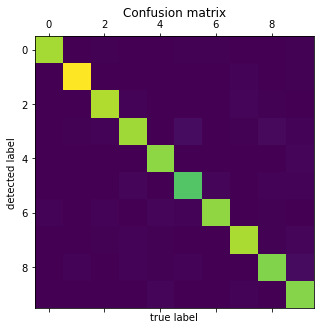

The 10 most mislabeled pairs are:
[3, 5] 0.38 %
[8, 9] 0.31 %
[3, 8] 0.28 %
[7, 9] 0.21 %
[6, 4] 0.21 %
[2, 7] 0.2 %
[5, 3] 0.19 %
[9, 4] 0.18 %
[4, 9] 0.15 %
[5, 6] 0.14 %


0.9453

In [427]:
perc.accuracy(test_data[0],test_data[1],1)

In [ ]:
#Make a grid search function for maybe learning rate, size of hidden layers and maybe number of hidden layers

#Compare performance with AI for beginners' method

#The grid search will try different values for lr, size of hidden layers and number of hidden layers. 
#We will assume that the number of epochs brings an increase in accuracy as the number of epochs increases regardless of 
#the other parameters, so we will only try increasing number of epochs once we have found the best values for the rest of 
#parameters, and we will stop once the accuracy plateaus. 

#The derivatives have sums over the dimensions of the layers, so bigger layers should have bigger derivatives and need smaller
#learning rates

In [428]:
def Grid_Search(parameters,training_data,training_labels,validation_data,validation_labels):
    #parameters is a dict with the name of the parameter as key and the possible values as value
    #parameters = {'Learning_Rate': [],
    #              'Number of Hidden Layers': [],
    #              'Number of nodes in a hidden layer': []
    #             }
    
    accuracy = []
    
    inputlayer = [training_data.shape[1]]
    outputlayer = [max(training_labels)+1]
    for i,nhd in enumerate(parameters['Number of Hidden Layers']):
        accuracy.append({})
        #list of list with all the combinations of number of nodes for every hidden layer
        combinations = comb_rep_n(nhd,parameters['Number of nodes in a hidden layer'])
        for comb in combinations:
            layers = inputlayer + comb + outputlayer
            perc = Perceptron(layers)
            for lr in parameters['Learning_Rate']:
                batch = 5
                perc.train(training_data,training_labels,lr,batch)
                acc = perc.accuracy(validation_data,validation_labels)
                accuracy[i].update( {'hidden layers:'+str(lts(comb))+', lr:'+str(lr):acc} )
                
    return accuracy
    

In [429]:
def add_1_of_each(lili,B):
    lol = []
    for li in lili:
        for m in range(len(B)):
            li.append(B[m])
            lmao = li[:]
            lol.append(lmao)
            li.pop(-1)
    return lol

def comb_rep_n(n,B,inp=[[]]):
    for k in range(n):
        inp = add_1_of_each(inp,B)
    return inp

def lts(li):
    return [str(a) for a in li]

In [430]:
parameters = {'Learning_Rate': [0.0001,0.001,0.01,0.1],
              'Number of Hidden Layers': [1,2,3],
              'Number of nodes in a hidden layer': [10,20,30,40,50]
             }
#the total number of trials is 
#( sum_nhd (len(nn)^nhd) )* len(nlr)
#(5^1 + 5^2 + 5^3) * 4 = 620

In [434]:
parameters = {'Learning_Rate': [0.001],
              'Number of Hidden Layers': [1,2],
              'Number of nodes in a hidden layer': [20,40]
             }
#the total number of trials is 
#( sum_nhd (len(nn)^nhd) )* len(nlr)
#(2^1 + 2^2) * 1 = 5

In [435]:
Grid_Search(parameters,training_data[0],training_data[1],validation_data[0],validation_data[1])

Accuracy:  0.9152
Accuracy:  0.9157
Accuracy:  0.9149
Accuracy:  0.9154
Accuracy:  0.9181
Accuracy:  0.9196


[{"hidden layers:['20'], lr:0.8": 0.9152,
  "hidden layers:['40'], lr:0.8": 0.9157},
 {"hidden layers:['20', '20'], lr:0.8": 0.9149,
  "hidden layers:['20', '40'], lr:0.8": 0.9154,
  "hidden layers:['40', '20'], lr:0.8": 0.9181,
  "hidden layers:['40', '40'], lr:0.8": 0.9196}]

___

# Using AI for beginners' method

For building a perceptron framework we need 5 elements, which will be in the form of classes:

- linear transformation
- hidden layer activation function
- softmax activation function
- loss function ??????????????????????????
- stackable network framework

All element except the network framework have a forward pass to calculate the probabilities of the classes and a backward pass to calculate the derivatives of the weights through backpropagation. 
The loss function is a cross entropy function and the output layer uses a softmax activation function, since that is what I assumed for my mathematical resolution, but any hidden layer activation function can be used. In particular I will be using tanh since it is a simple function to differentiate. 


In [274]:
class Linear:

    def __init__(self,input_dimension,output_dimension):
        self.W = np.random.normal(0,1.0/np.sqrt(input_dimension), (output_dimension,input_dimension))
        self.b = np.zeros((output_dimension))        

    def forward(self,x): 
        return np.dot(self.W,x) + self.b 

    def backward(self):
        return 
    
x = np.array([1,-2,0,-1,2])
lll = Linear(5,3)
print(lll.forward(x))

[-0.88184657 -0.74112329 -0.16958856]


In [276]:
class Softmax:
    def forward(self,z):
        expz = np.exp(z)
        Z = expz.sum(keepdims=True)
        self.p = expz / Z
        return self.p

    def backward(self):
        return 1

softm = Softmax()
print(softm.forward(x))

[0.23412166 0.01165623 0.08612854 0.03168492 0.63640865]


In [277]:
class Activation_function:
    def forward(self,z):
        self.y = np.tanh(z)
        return self.y #tanh squishes values between -1 and 1 

activ = Activation_function()
activ.forward(x)

array([ 0.76159416, -0.96402758,  0.        , -0.76159416,  0.96402758])

In [278]:
class loss_function:
    def forward(self,p,labels):
        p_of_true = p[np.arange(len(labels)), labels]
        return -np.log(p_of_true).mean()

crossloss = loss_function()
p = np.array([[0.01,0.1,0.7,0.1,0.05,0.04],[0.84,0.01,0.01,0.05,0.05,0.04]])
l = np.array([2,0])
crossloss.forward(p,l) 

#Might be better as a function since I am not calling it to calculate derivatives only the loss itself, so it gets called only 
#once at the end of the training epoch or training process

0.2655141655417551

_____

## Training

In [39]:
#%matplotlib nbagg
import matplotlib.pyplot as plt 
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np
# pick the seed for reproducibility - change it to explore the effects of random variations
np.random.seed(0)
import random

In [35]:
n = 100
X, Y = make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0.2)
X = X.astype(np.float32)
Y = Y.astype(np.int32)

# Split into train and test dataset
train_x, test_x = np.split(X, [n*8//10])
train_labels, test_labels = np.split(Y, [n*8//10])

In [36]:
#in progress
net = Network()
net.add(Output_Layer(2,2))
learning_rate = 0.1


pred = np.argmax(net.forward(train_x),axis=1)
acc = (pred==train_labels).mean()
print("Initial accuracy: ",acc)

batch_size=4
for i in range(0,len(train_x),batch_size):
    xb = train_x[i:i+batch_size]
    yb = train_labels[i:i+batch_size]
    
    # forward pass
    #z = lin.forward(xb)
    #p = softmax.forward(z)
    #loss = cross_ent_loss.forward(p,yb)
    
    p = net.forward(xb)
    
    
    # backward pass
    net.backward(yb)
    net.update(learning_rate)
    #dp = cross_ent_loss.backward(loss)
    #dz = softmax.backward(dp)
    #dx = lin.backward(dz)
    #lin.update(learning_rate)
    
pred = np.argmax(net.forward(train_x),axis=1)
acc = (pred==train_labels).mean()
print("Final accuracy: ",acc)


Initial accuracy:  0.2125
Final accuracy:  0.825


_____

In [ ]:
#class definition in progress for (784,) as input vector
class Hidden_Layer_singlevec():
    def __init__(self,input_dimension,output_dimension,batch):
        self.W = np.random.normal(0,1.0/np.sqrt(input_dimension), (output_dimension,input_dimension))
        self.b = np.zeros((1,output_dimension))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
    def linear_forward(self,x):
        self.yn_1 = x                       #storing y(n-1) for later
        return np.dot(self.W,x) + self.b    #returns the linear transformation
    
    def activation_forward(self,z):
        y = np.tanh(z)
        self.da = 1-y*y                     #storing a'(n) for layer
        return y                            #tanh squishes values between -1 and 1
    
    def backward(self,A_prev):
        #calculate A of this layer
        #AN1 = np.matmul(WN1.T,np.multiply(AN,a'N1))
        
        #calculate derivatives of this layer using An_1
        #np.matmul(np.multiply(AN,a'N1),yN2.T)
        #np.multiply(AN,a'N1)
        
        #store derivatives but not any A since they are fed as inputs
        
        #return A
        
        Ada = np.multiply(A_prev,self.da)
        
        A = np.matmul(self.W.T,Ada)
        
        dW = np.matmul(Ada,self.yn_1.T)
        db = Ada
        
        #takes An as input
        #calculates and stores derivatives
        #returns An-1
        
        return A
        
    def update(lr):
        #the derivatives are already stored
        #remember the - signs that can be removed
        
        #change W and b by derivatives no returning anything
        
        
        
hid = Hidden_Layer(5,3)
print(1-hid.activation_forward(hid.linear_forward(x))*hid.activation_forward(hid.linear_forward(x)),hid.da)
